In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA # Updated to use the new ARIMA implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels
print(statsmodels.__version__)
import pmdarima
print(pmdarima.__version__)

0.13.1
1.8.4


In [2]:
#read in data
df = pd.read_csv('data/final_df.csv')
display(df.head())
display(df.shape)

,date,neg,neu,pos,compound,nominal,bdc
0,2014-01-01,0.208167,0.720500,0.071167,-0.188100,157.26,172.0
1,2014-01-02,0.026113,0.944050,0.029843,0.015256,157.26,172.0
2,2014-01-03,0.140405,0.698167,0.161714,0.046255,157.26,172.0
3,2014-01-04,0.130111,0.797444,0.072444,-0.154944,157.26,172.0
4,2014-01-05,0.074286,0.763714,0.162000,0.167800,157.26,172.0


(2527, 7)

In [3]:
#creating column for change in exchange rate
df['bdc_change']= df['bdc'].pct_change()

In [4]:
#confirm there are no nulls
df.isnull().sum()

date          0
neg           0
neu           0
pos           0
compound      0
nominal       0
bdc           0
bdc_change    1
dtype: int64

In [5]:
#dropping null
df.dropna(inplace= True)
df.isnull().sum()

date          0
neg           0
neu           0
pos           0
compound      0
nominal       0
bdc           0
bdc_change    0
dtype: int64

## Testing for Stationarity

<AxesSubplot:>

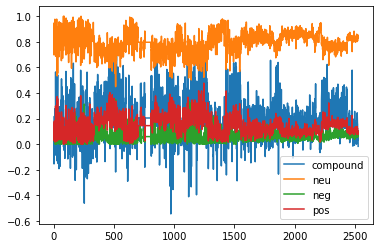

In [6]:
#visualize data
df[['compound','neu','neg','pos']].plot()

By vizualization, data on sentiment scores appear to be stationary. However, we can confirm with ADF test.

In [7]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [8]:
#applying function to column
interpret_dftest(adfuller(df['compound']))

Test Statistic   -4.691887
p-value           0.000087
dtype: float64

The p value is significant at 1%, 5% and 10% levels of significance, hence we fail to reject the hypothesis that the series is stationary.

In [9]:
#applying function to column
interpret_dftest(adfuller(df['neg']))

Test Statistic   -1.364261e+01
p-value           1.642208e-25
dtype: float64

The p value is significant at 1%, 5% and 10% levels of significance, hence we fail to reject the hypothesis that the series is stationary.

In [10]:
#applying function to column
interpret_dftest(adfuller(df['pos']))

Test Statistic   -3.206704
p-value           0.019600
dtype: float64

The p value is significant at 1%, 5% and 10% levels of significance, hence we fail to reject the hypothesis that the series is stationary.

<AxesSubplot:>

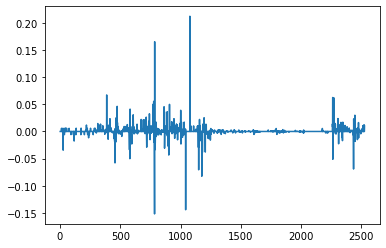

In [11]:
df['bdc_change'].plot()

By vizualization, the series appears to the stationary. However, we can confirm with ADF test.

In [12]:
interpret_dftest(adfuller(df['bdc_change']))

Test Statistic   -20.291628
p-value            0.000000
dtype: float64

The p value is significant at 1%, 5% and 10% levels of significance, hence we fail to reject the hypothesis that the series is stationary.

<AxesSubplot:>

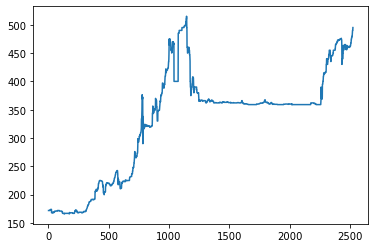

In [13]:
df['bdc'].plot()

There appears to be a trend in the series. However, we can confirm with ADF test.

In [14]:
#applying function to column
interpret_dftest(adfuller(df['bdc']))

Test Statistic   -1.023894
p-value           0.744450
dtype: float64

The p value is not significant at 1%, 5% and 10% levels of significance, hence we reject the hypothesis that the series is stationary.

In [15]:
df['first_diff_bdc'] = df['bdc'].diff(1)

In [16]:
interpret_dftest(adfuller(df['first_diff_bdc'].dropna()))

Test Statistic   -20.165323
p-value            0.000000
dtype: float64

The p value is significant at 1%, 5% and 10% levels of significance, hence we can conclude that the series is stationary at first difference.

## Preprocessing

In [17]:
#creating lagged versions of sentiment scores
df['compound_lag_1'] = df['compound'].shift(1)
df['compound_lag_2'] = df['compound'].shift(2)
df['compound_lag_3'] = df['compound'].shift(3)

In [18]:
#creating lagged versions of sentiment scores
df['pos_lag_1'] = df['pos'].shift(1)
df['pos_lag_2'] = df['pos'].shift(2)
df['pos_lag_3'] = df['pos'].shift(3)

In [19]:
#creating lagged versions of sentiment scores
df['neg_lag_1'] = df['neg'].shift(1)
df['neg_lag_2'] = df['neg'].shift(2)
df['neg_lag_3'] = df['neg'].shift(3)

In [20]:
#dropping nulls
df.dropna(inplace= True)

In [21]:
df.shape

(2523, 18)

In [22]:
#setting date column as datetime index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [23]:
#splitting into train & test sets. This will be used for VAR model.
df_train, df_test = train_test_split(df[['bdc_change','compound', 'pos', 'neg']], 
                                     shuffle = False, random_state = 42)

In [24]:
#confirming shape
df_train.shape, df_test.shape

((1892, 4), (631, 4))

In [25]:
#defining X and y variables 
X = df[['compound_lag_1', 'pos_lag_1', 'neg_lag_1']]
y = df['bdc_change']

In [26]:
#Splitting X & y into train and test sets. This will be used for SARIMAX & ARDL models.
train_size=int(len(df) *0.75)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [27]:
#confirming dimensions
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1892, 3), (1892,), (631, 3), (631,))

## VAR Model

In [28]:
#decide the order (P) of VAR model i.e. decide which lag is best to fit the model
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Lag Order = 1
AIC :  -26.431353147312524
BIC :  -26.37270839777621
FPE :  3.3190148863243643e-12
HQIC:  -26.409758928838624 

Lag Order = 2
AIC :  -26.483703827769954
BIC :  -26.378097501902264
FPE :  3.149732649649207e-12
HQIC:  -26.444816339496853 

Lag Order = 3
AIC :  -26.5300154725177
BIC :  -26.377406817615594
FPE :  3.007191277130124e-12
HQIC:  -26.473818782707376 

Lag Order = 4
AIC :  -26.537629446179597
BIC :  -26.337977651912663
FPE :  2.9843847646037495e-12
HQIC:  -26.4641075999191 

Lag Order = 5
AIC :  -26.549762153818122
BIC :  -26.3030263521165
FPE :  2.948399963156604e-12
HQIC:  -26.458899172973698 

Lag Order = 6
AIC :  -26.560430899185143
BIC :  -26.266570164127167
FPE :  2.917118833835319e-12
HQIC:  -26.452210782356246 

Lag Order = 7
AIC :  -26.563180457601668
BIC :  -26.22215380530123
FPE :  2.909119243528872e-12
HQIC:  -26.43758718007485 

Lag Order = 8
AIC :  -26.564166755963345
BIC :  -26.17593314445698
FPE :  2.9062648305305386e-12
HQIC:  -26.421184269666036 


Lag order 9 is preferred as this is the order at which the AIC is lowest.

In [29]:
#select preferred lag order
model.select_order(9)

In [30]:
#fit model
results = model.fit(maxlags = 9, ic = 'aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Dec, 2021
Time:                     21:23:33
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.1315
Nobs:                     1883.00    HQIC:                  -26.4066
Log likelihood:           14473.4    FPE:                2.89813e-12
AIC:                     -26.5670    Det(Omega_mle):     2.68111e-12
--------------------------------------------------------------------
Results for equation bdc_change
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000225         0.000923           -0.244           0.807
L1.bdc_change        -0.034357         0.023284           -1.476           0.140
L1.compound          -0.000304         0.003847        

In [31]:
#checking for the presence of autocorrelation
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df_train.columns, out):
    print(col, ':', round(val, 2))

bdc_change : 2.0
compound : 2.0
pos : 2.01
neg : 2.0


Durbin watson statistic is approximately 2. Hence we can conclude that there is no autocorrelation in the model i.e. no significant correlation between the residuals of the explanatory variables.

In [32]:
#fit preferred VAR model
model = VAR(df_train)
model_fitted = model.fit(9)

#get lag order
lag_order = model_fitted.k_ar
print(lag_order)

9


/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [33]:
maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train, variables = df_train.columns)  
#reference: https://rishi-a.github.io/2020/05/25/granger-causality.html

,bdc_change_x,compound_x,pos_x,neg_x
bdc_change_y,1.0000,0.0221,0.2052,0.0046
compound_y,0.0587,1.0000,0.0000,0.0000
pos_y,0.2817,0.1668,1.0000,0.0001
neg_y,0.0338,0.0000,0.0004,1.0000


If a given p value is significant, then the corresponding X series (column) causes the response Y series (row). 

The above result shows bi-directional causality running from the rate of change of the exchange rate to negative and compound sentiment scores and vice versa. There appears to be no causal relationship between the rate of change in exchange rate, and positive sentiment scores in the period studied.

## Forecasting - SARIMAX Model

In [34]:
decomposed_result = seasonal_decompose(df.compound, model = "additive", period = 1)

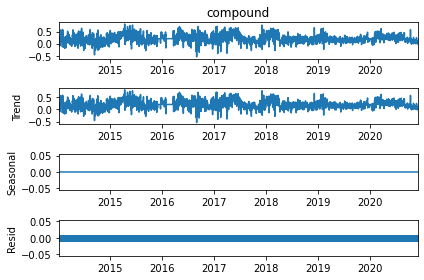

In [35]:
# plot decomposition
decomposed_result.plot();

We can infer from the plot above that there is no seasonality in the model.

In [36]:
#instantiate auto arima to determine optimal parameters for SARIMAX model

sarimax = auto_arima(
    train_y, 
    exogenous = train_X, 
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    d = 0, 
    seasonal = False, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True  
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11832.379, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11831.946, Time=0.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11831.993, Time=0.84 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11828.521, Time=1.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-11830.383, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 4.140 seconds


In [37]:
train_X.shape, train_y.shape

((1892, 3), (1892,))

In [38]:
order = (0, 0, 0)

# instantiate
sarimax = SARIMAX(
    train_y,
    train_X, 
    order = order, 
    freq = "D",
    enforce_stationarity = False,
)

fitted_sarimax = sarimax.fit(maxiter = 10_000, method = "powell", disp = 0) 

/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [39]:
# check model summary
fitted_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             bdc_change   No. Observations:                 1892
Model:                        SARIMAX   Log Likelihood                5916.573
Date:                Thu, 23 Dec 2021   AIC                         -11825.146
Time:                        21:23:39   BIC                         -11802.967
Sample:                    01-05-2014   HQIC                        -11816.979
                         - 03-11-2019                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
compound_lag_1     0.0005      0.005      0.103      0.918      -0.010       0.011
pos_lag_1         -0.0040      0.010     -0.399      0.690      -0.023       0.016
neg_lag_1          0.0156      0.010      1.571      0.116      -0.004       0.035
sigma2             0.0001   5.08e-07    220.610      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):           2070963.38
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                       165.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [40]:
forecast_sarimax= fitted_sarimax.forecast(steps=test_size, exog=test_X)

<AxesSubplot:>

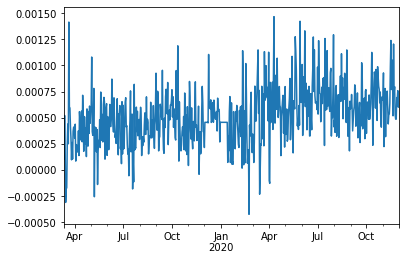

In [41]:
preds_df= pd.DataFrame(forecast_sarimax)
preds_df['predicted_mean'].plot()

In [42]:
# Set up the orders
order          = (0,0,0)

# storing new test predictions, the history, and confidence intervals
sarimax_preds = []
history = train_y.values
conf_ints = []

# for each test observation...
for val in test_y:
    # create model
    sarima = SARIMAX(history, order = order, enforce_stationarity = False)
    # fit
    fitted_sarimax = sarima.fit(method = "powell", maxiter = 10_000, disp = 0) # stop excessive ouput with disp = 0
    # make next out-of-sample prediction
    pred_obj = fitted_sarimax.get_forecast(steps = 1)
    # add to preds and conf_ints
    sarimax_preds.append(pred_obj.predicted_mean)
    conf_ints.append(pred_obj.conf_int()[0])

    # add TRUTH to history for next training
    history = np.append(history, val)

In [43]:
test_y.shape

(631,)

In [44]:
# setting up info for visualization
new_test_preds = pd.Series(sarimax_preds, index = test_y.index)

# converting list to numpy array for convenience
lower_conf_int = np.array(conf_ints)[:,0]
upper_conf_int = np.array(conf_ints)[:,1]

In [45]:
#function to plot preds

def plot_SARIMA_predictions(y_train, y_test = None, train_preds = None, test_preds = None, lower_conf_int = None, upper_conf_int = None, title = "Title", ylabel = "{y_label}",xlabel = "Data"):
    plt.figure(figsize=(12,5))
    plt.title(title)

    # train data
    plt.plot(y_train.index, y_train, lw=1, color='purple', ls='solid', label='Train Data')

    # train prediction
    if train_preds is not None:
        plt.plot(train_preds.index, train_preds, lw=1, color='green', ls='dashed', label='Training Predictions')

    # test data
    if y_test is not None:
        plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

    # test predictions
    if test_preds is not None:
        plt.plot(test_preds.index, test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

    #  labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # confidence intervals
    if lower_conf_int is not None and upper_conf_int is not None:
        plt.fill_between(y_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1,  label ="95% conf. int.");
    # legend
    plt.legend(loc = "upper left");
    
#credit: GA DSI-927 course material

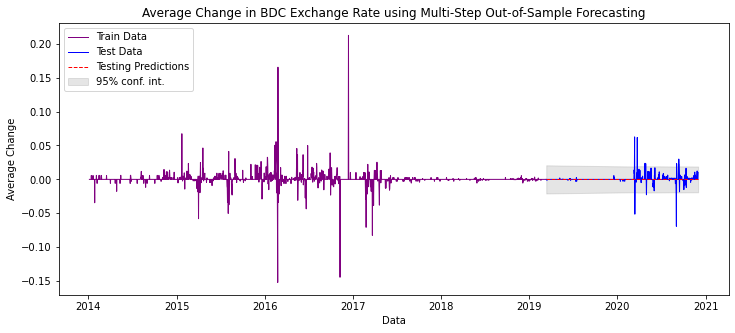

In [46]:
# plotting Multi-Step Out-of-Sample Forecasting
plot_SARIMA_predictions(
    train_y, 
    test_y,
    test_preds = new_test_preds,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "Average Change in BDC Exchange Rate using Multi-Step Out-of-Sample Forecasting",
    ylabel = "Average Change"
)
plt.savefig('images/Average Change in BDC Exchange Rate using Multi-Step Out-of-Sample Forecasting')

In [47]:
# Evaluating Multi-Step Out-of-Sample Forecasting 
print(r2_score(test_y, new_test_preds))
print(mean_squared_error(test_y, new_test_preds))

-0.007212789517453189
3.8664210909177175e-05


The accuracy score and mean squared error were negligible. The model did not do a good job of churning out accurate forecasts.

## ARDL Model
Reference: https://www.statsmodels.org/devel/examples/notebooks/generated/autoregressive_distributed_lag.html

In [48]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.api import UECM

In [49]:
df.head()

,neg,neu,pos,compound,nominal,bdc,bdc_change,first_diff_bdc,compound_lag_1,compound_lag_2,compound_lag_3,pos_lag_1,pos_lag_2,pos_lag_3,neg_lag_1,neg_lag_2,neg_lag_3
date,,,,,,,,,,,,,,,,,
2014-01-05,0.074286,0.763714,0.162000,0.167800,157.26,172.0,0.0,0.0,-0.154944,0.046255,0.015256,0.072444,0.161714,0.029843,0.130111,0.140405,0.026113
2014-01-06,0.115700,0.813500,0.070900,-0.083350,157.28,172.0,0.0,0.0,0.167800,-0.154944,0.046255,0.162000,0.072444,0.161714,0.074286,0.130111,0.140405
2014-01-07,0.083586,0.735793,0.180621,0.218283,157.28,172.0,0.0,0.0,-0.083350,0.167800,-0.154944,0.070900,0.162000,0.072444,0.115700,0.074286,0.130111
2014-01-08,0.130800,0.756343,0.112943,-0.010109,157.28,172.0,0.0,0.0,0.218283,-0.083350,0.167800,0.180621,0.070900,0.162000,0.083586,0.115700,0.074286
2014-01-09,0.023250,0.884500,0.092167,0.168783,157.28,172.0,0.0,0.0,-0.010109,0.218283,-0.083350,0.112943,0.180621,0.070900,0.130800,0.083586,0.115700


In [50]:
#get optimal ardl order
ardl_order = ardl_select_order(df.bdc_change,3, df[['compound','neg','pos']],
                              3, ic = 'aic', trend = "c")
print(f'The optimal order is: {ardl_order.model.ardl_order}')

/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


The optimal order is: (3, 1, 0)


/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [51]:
#fit model and view summary
fitted_ardl = ardl_order.model.fit()
fitted_ardl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:             bdc_change   No. Observations:                 2523
Model:                  ARDL(3, 1, 0)   Log Likelihood                8118.791
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Thu, 23 Dec 2021   AIC                         -16221.581
Time:                        21:24:16   BIC                         -16174.925
Sample:                             3   HQIC                        -16204.650
                                 2523                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.001      0.181      0.857      -0.001       0.001
bdc_change.L1    -0.0359      0.020     -1.803      0.071      -0.075       0.003
bdc_change.L2    -0.0099      0.020     -0.499      0.618      -0.049       0.029
bdc_change.L3     0.0606      0.020      3.047      0.002       0.022       0.100
neg.L0            0.0042      0.005      0.848      0.397      -0.005       0.014
neg.L1            0.0141      0.005      2.871      0.004       0.004       0.024
pos.L0           -0.0049      0.003     -1.726      0.084      -0.011       0.001
=================================================================================
"""

## Unconstrained Error Correction Models (UECM)

Unconstrained Error Correction Models reparameterize ARDL model to focus on the long-run component of a time series. 

In [52]:
#get optimal ardl order for uecm model
ardl_order_uecm = ardl_select_order (df.bdc_change, 3, df[['compound','neg']],
                                     3, ic = 'aic', trend = 'c'
)

ecm =  UECM.from_ardl(ardl_order_uecm.model)
ecm_fitted = ecm.fit()
ecm_fitted.summary()

/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nnenna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ardl/model.py:158: SpecificationWa

<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:           D.bdc_change   No. Observations:                 2523
Model:                     UECM(3, 1)   Log Likelihood                8117.297
Method:               Conditional MLE   S.D. of innovations              0.014
Date:                Thu, 23 Dec 2021   AIC                         -16220.594
Time:                        21:24:16   BIC                         -16179.770
Sample:                             3   HQIC                        -16205.779
                                 2523                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0006      0.000     -1.569      0.117      -0.001       0.000
bdc_change.L1      -0.9839      0.035    -27.770      0.000      -1.053      -0.914
neg.L1              0.0181      0.006      3.172      0.002       0.007       0.029
D.bdc_change.L1    -0.0518      0.029     -1.806      0.071      -0.108       0.004
D.bdc_change.L2    -0.0615      0.020     -3.090      0.002      -0.101      -0.022
D.neg.L0            0.0047      0.005      0.951      0.342      -0.005       0.014
===================================================================================
"""

### Checking for Cointegration

In [53]:
#view model summary
ecm_fitted.ci_summary()

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0006,0.000,1.571,0.116,-0.000,0.001
bdc_change.L1,1.0000,0,nan,nan,1.000,1.000
neg.L1,-0.0184,0.006,-3.190,0.001,-0.030,-0.007


<AxesSubplot:title={'center':'Cointegrating Error'}, xlabel='date'>

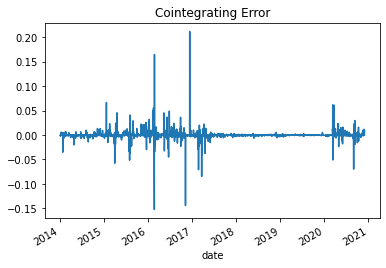

In [54]:
#plot residuals
ecm_fitted.ci_resids.plot(title ="Cointegrating Error")

## Conclusion

- Yes, twitter sentiments can help to predict the trend of exchange rate in Nigeria.
- Study specified 3 models – Granger Causality,  ARDL & SARIMAX in analyzing the relationship between NGN/USD exchange rate and sentiments from 116,330 tweets by 51,226 users between 2014 and 2020.
- Granger Causality Test showed bi-directional causality running from (negative) sentiments to exchange rate & vice versa.  
- ARDL model corroborated this finding as a significant long run relationship was reported for (negative) sentiments and exchange rate movements.


## Recommendations

- For future analysis, this study recommends scaling up the number of tweets analyzed to improve reliability of results.

- Future analysis could decompose sentiments into moods to better understand the nature of the relationship.

- There is potential to apply approach to forecasting other macroeconomic variables.
